In [44]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


In [46]:
DTtrainingdata = pd.read_csv('/content/train_data.csv',nrows=55000)
DTresourcescsvdata = pd.read_csv('/content/resources.csv')
print("Decision Tree Training data", DTtrainingdata.shape)
print("Decision Tree Attributes of training data :", DTtrainingdata.columns.values)
print("Decision Tree Resources attributes data ", DTresourcescsvdata.shape)
psecol = ['Date' if pse=='project_submitted_datetime' else pse for pse in list(DTtrainingdata.columns)]
DTtrainingdata['Date'] = pd.to_datetime(DTtrainingdata['project_submitted_datetime'])
DTtrainingdata.drop('project_submitted_datetime', axis=1, inplace=True)
DTtrainingdata.sort_values(by=['Date'], inplace=True)
DTtrainingdata = DTtrainingdata[psecol]

Decision Tree Training data (55000, 17)
Decision Tree Attributes of training data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
Decision Tree Resources attributes data  (1541272, 4)


Decision Tree Data processing

In [47]:
import re
from collections import Counter

DTtrainingdata["essay"] = DTtrainingdata["project_essay_1"].map(str) +\
                        DTtrainingdata["project_essay_2"].map(str) + \
                        DTtrainingdata["project_essay_3"].map(str) + \
                        DTtrainingdata["project_essay_4"].map(str)

def decontractedDT(phraseDT):
    phraseDT = re.sub(r"won't", "will not", phraseDT)
    phraseDT = re.sub(r"can\'t", "can not", phraseDT)
    phraseDT = re.sub(r"n\'t", " not", phraseDT)
    phraseDT = re.sub(r"\'re", " are", phraseDT)
    phraseDT = re.sub(r"\'s", " is", phraseDT)
    phraseDT = re.sub(r"\'d", " would", phraseDT)
    phraseDT = re.sub(r"\'ll", " will", phraseDT)
    phraseDT = re.sub(r"\'t", " not", phraseDT)
    phraseDT = re.sub(r"\'ve", " have", phraseDT)
    phraseDT = re.sub(r"\'m", " am", phraseDT)
    return phraseDT

stopwordsremoval= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

#project_subject_categories Decision Tree Data Preprocessing 

DTsubjectcatogories = list(DTtrainingdata['project_subject_categories'].values)

DTsubjectcatogorieslist = []
for DTindexvalue in DTsubjectcatogories:
    DTtemporaryvariableforsubjectcatories = ""
    for DTjvalue in DTindexvalue.split(','):
        if 'The' in DTjvalue.split():
            DTjvalue=DTjvalue.replace('The','')
        DTjvalue = DTjvalue.replace(' ','')
        DTtemporaryvariableforsubjectcatories+=DTjvalue.strip()+" "
        DTtemporaryvariableforsubjectcatories = DTtemporaryvariableforsubjectcatories.replace('&','_')
    DTsubjectcatogorieslist.append(DTtemporaryvariableforsubjectcatories.strip())
    
DTtrainingdata['clean_categories'] = DTsubjectcatogorieslist
DTtrainingdata.drop(['project_subject_categories'], axis=1, inplace=True)


DTcustomcounter = Counter()
for DTextractingword in DTtrainingdata['clean_categories'].values:
    DTcustomcounter.update(DTextractingword.split())

DTdictforcategory = dict(DTcustomcounter)
DTdictforsortcategory = dict(sorted(DTdictforcategory.items(), key=lambda kv: kv[1]))

#Decision Tree project_subject_subcategories Preprocessing

DTsubsubjectcatogories = list(DTtrainingdata['project_subject_subcategories'].values)

DTsubsubjectcatogorieslist = []
for DTindexvaluesub_catogories in DTsubsubjectcatogories:
    DTtemporaryvariableforsubsubjectcatories = ""
    for DTjvalue in DTindexvaluesub_catogories.split(','):
        if 'The' in DTjvalue.split():
            DTjvalue=DTjvalue.replace('The','')
        DTjvalue = DTjvalue.replace(' ','')
        DTtemporaryvariableforsubsubjectcatories +=DTjvalue.strip()+" "
        DTtemporaryvariableforsubsubjectcatories = DTtemporaryvariableforsubsubjectcatories.replace('&','_')
    DTsubsubjectcatogorieslist.append(DTtemporaryvariableforsubsubjectcatories.strip())

DTtrainingdata['clean_subcategories'] = DTsubsubjectcatogorieslist
DTtrainingdata.drop(['project_subject_subcategories'], axis=1, inplace=True)

DTsubcustomcounter = Counter()
for DTsubextractingword in DTtrainingdata['clean_subcategories'].values:
    DTsubcustomcounter.update(DTsubextractingword.split())
    
DTsubdictforcategory = dict(DTsubcustomcounter)
DTsubdictforsortcategory = dict(sorted(DTsubdictforcategory.items(), key=lambda kv: kv[1]))

print(DTtrainingdata['project_grade_category'][:15])

dpgradry= list(DTtrainingdata['project_grade_category'].values)

DTgradcaist = []
for DTindexvalue in dpgradry:
    for DTjvalue in DTindexvalue.split(' '):
        DTjvalue=DTjvalue.replace('Grades','')
    DTgradcaist.append(DTjvalue.strip())
    
DTtrainingdata['clean_grade'] = DTgradcaist
DTtrainingdata.drop(['project_grade_category'], axis=1, inplace=True)

DTcustomcounter = Counter()
for DTsubextractingword in DTtrainingdata['clean_grade'].values:
     DTcustomcounter.update(DTsubextractingword.split())
projecgradcatdict= dict(DTcustomcounter)
sorprojecgradcatdict = dict(sorted(projecgradcatdict.items(), key=lambda kv: kv[1]))

51140    Grades PreK-2
473      Grades PreK-2
41558       Grades 3-5
29891       Grades 3-5
23374    Grades PreK-2
49228    Grades PreK-2
7176     Grades PreK-2
35006       Grades 3-5
5145        Grades 3-5
48237      Grades 9-12
52282      Grades 9-12
46375       Grades 3-5
36468    Grades PreK-2
36358    Grades PreK-2
39438    Grades PreK-2
Name: project_grade_category, dtype: object


Train Split Decision Tree

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DTtrainingdata, DTtrainingdata['project_is_approved'],stratify = DTtrainingdata['project_is_approved'], test_size=0.33)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify= y_train,test_size = 0.33)
print(y_train.value_counts())
print(y_test.value_counts())
print(y_cv.value_counts())

X_train.drop(["project_is_approved"], axis = 1, inplace = True)

X_test.drop(["project_is_approved"], axis = 1, inplace = True)

X_cv.drop(["project_is_approved"], axis = 1, inplace = True)

#Decision Tree Data preprocessing

#Essay Decision Tree Proprocessing  
from tqdm import tqdm
DTpreprocessessayrain = []
for DTsenta in tqdm(X_train['essay'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocessessayrain.append(DTsen.lower().strip())

#Essay Decision Tree Proprocessing 
from tqdm import tqdm
DTpreprocesssatest = []
for DTsenta in tqdm(X_test['essay'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocesssatest.append(DTsen.lower().strip())

#Essay Decision Tree Proprocessing 
from tqdm import tqdm
DTpreprocessssaycv = []
for DTsenta in tqdm(X_cv['essay'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocessssaycv.append(DTsen.lower().strip())

#Project title Decision Tree Proprocessing
from tqdm import tqdm
DTpreprocessetitlecv = []
for DTsenta in tqdm(X_cv['project_title'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocessetitlecv.append(DTsen.lower().strip())

#Project title Decision Tree Proprocessing
from tqdm import tqdm
DTpreprocesseitle = []
# tqdm is for printing the status bar
for DTsenta in tqdm(X_train['project_title'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocesseitle.append(DTsen.lower().strip())

#Project title Decision Tree Proprocessing
from tqdm import tqdm
DTpreprocesitleest = []
for DTsenta in tqdm(X_test['project_title'].values):
    DTsen = decontractedDT(DTsenta)
    DTsen = DTsen.replace('\\r', ' ')
    DTsen = DTsen.replace('\\"', ' ')
    DTsen = DTsen.replace('\\n', ' ')
    DTsen = re.sub('[^A-Za-z0-9]+', ' ', DTsen)
    DTsen = ' '.join(eDT for eDT in DTsen.split() if eDT.lower() not in stopwordsremoval)
    DTpreprocesitleest.append(DTsen.lower().strip())

1    13998
0     2543
Name: project_is_approved, dtype: int64
1    15361
0     2789
Name: project_is_approved, dtype: int64
1    6896
0    1252
Name: project_is_approved, dtype: int64


100%|██████████| 18150/18150 [00:00<00:00, 30277.82it/s]


Decision Tree Vectorizing Categorical features and Encoding numerical

In [49]:
#Converting categorical Decision Tree Data to vectors for project_subject_categories and convert training data, cross validation and testing data and convert to vectors
from sklearn.feature_extraction.text import CountVectorizer
DToneveccleancat = CountVectorizer(vocabulary=list(DTdictforsortcategory.keys()), lowercase=False,binary=True)
DToneveccleancat.fit(X_train['clean_categories'].values)
DTtrraiat = DToneveccleancat.transform(X_train['clean_categories'].values)
DTXcvcat = DToneveccleancat.transform(X_cv['clean_categories'].values)
DTtestat = DToneveccleancat.transform(X_test['clean_categories'].values)
print(DToneveccleancat.get_feature_names())

DTonefeature=DToneveccleancat.get_feature_names()
print("Vector Shape")
print(DTtrraiat.shape, y_train.shape)
print(DTXcvcat.shape, y_cv.shape)
print(DTtestat.shape, y_test.shape)

#Converting categorical Decision Tree Data to vectors for project_subject_subcategories and convert training data, cross validation and testing data and convert to vectors
from sklearn.feature_extraction.text import CountVectorizer
DTtwoveccleancat = CountVectorizer(vocabulary=list(DTsubdictforsortcategory.keys()), lowercase=False, binary=True)
DTtwoveccleancat.fit(X_train['clean_subcategories'].values)
DTtrainsubcat = DTtwoveccleancat.transform(X_train['clean_subcategories'].values)
DTcvsubcat = DTtwoveccleancat.transform(X_cv['clean_subcategories'].values)
DTtessubcat = DTtwoveccleancat.transform(X_test['clean_subcategories'].values)
print(DTtwoveccleancat.get_feature_names())
print("Vector Shape")
print(DTtrainsubcat.shape, y_train.shape)
print(DTcvsubcat.shape, y_cv.shape)
print(DTtessubcat.shape, y_test.shape)

#Converting categorical Decision Tree Data to vectors for school_state and convert training data, cross validation and testing data and convert to vectors

from collections import Counter
DTcustomcounter = Counter()
for DTsubextractingword in DTtrainingdata['school_state'].values:
    DTcustomcounter.update(DTsubextractingword.split())
DTschootateict = dict(DTcustomcounter)
DTsortechoostatict = dict(sorted(DTschootateict.items(), key=lambda kv: kv[1]))
print(DTsortechoostatict)

#Converting categorical Decision Tree Data to vectors for clean_categories and convert training data, cross validation and testing data and convert to vectors

from sklearn.feature_extraction.text import CountVectorizer
DTthreeschool = CountVectorizer(vocabulary=list(DTsortechoostatict.keys()), lowercase=False, binary=True)
DTthreeschool.fit(DTtrainingdata['school_state'].values)
DTrainchootate = DTthreeschool.transform(X_train['school_state'].values)
DTcchootate = DTthreeschool.transform(X_cv['school_state'].values)
DTeschootate = DTthreeschool.transform(X_test['school_state'].values)
print(DTthreeschool.get_feature_names())

print("Vector Shape")
print(DTrainchootate.shape, y_train.shape)
print(DTcchootate.shape, y_cv.shape)
print(DTeschootate.shape, y_test.shape)

#Converting categorical Decision Tree Data to vectors for project_grade_category and convert training data, cross validation and testing data and convert to vectors
DTtrainingdata['clean_grade']=DTtrainingdata['clean_grade'].fillna("")
from sklearn.feature_extraction.text import CountVectorizer
DTfourgrade = CountVectorizer(vocabulary=list(sorprojecgradcatdict.keys()),lowercase=False, binary=True)
DTfourgrade.fit(DTtrainingdata['clean_grade'].values)
DTrairojecradategory = DTfourgrade.transform(X_train['clean_grade'].values)
DTrojecradategory = DTfourgrade.transform(X_cv['clean_grade'].values)
DTesrojecradategory = DTfourgrade.transform(X_test['clean_grade'].values)
print(DTfourgrade.get_feature_names())

print("Vector Shape")
print(DTrairojecradategory .shape, y_train.shape)
print(DTrojecradategory .shape, y_cv.shape)
print(DTesrojecradategory .shape, y_test.shape)

#Converting categorical Decision Tree Data to vectors for teacher_prefix and convert training data, cross validation and testing data and convert to vectors
DTtrainingdata['clean_grade']=DTtrainingdata['clean_grade'].fillna("")
DTtrainingdata['teacher_prefix']=DTtrainingdata['teacher_prefix'].fillna(" ")
DTcustomcounter = Counter()
for DTsubextractingword in DTtrainingdata['teacher_prefix'].values:
    DTcustomcounter.update(DTsubextractingword.split())
DTteachcatict = dict(DTcustomcounter)
DTsorteacherefiict = dict(sorted(DTteachcatict.items(), key=lambda kv: kv[1]))

#Converting categorical Decision Tree Data to vectors for clean_categories and convert training data, cross validation and testing data and convert to vectors
DTtrainingdata['clean_grade']=DTtrainingdata['clean_grade'].fillna("")# fill the null values with space
from sklearn.feature_extraction.text import CountVectorizer
DTfiveteacher = CountVectorizer(vocabulary=list(DTsorteacherefiict.keys()), lowercase=False,binary=True)
DTfiveteacher.fit(DTtrainingdata['teacher_prefix'].values.astype('U'))
DTraieachrefix = DTfiveteacher.transform(X_train['teacher_prefix'].values.astype('U'))
DTveacherefix= DTfiveteacher.transform(X_cv['teacher_prefix'].values.astype('U'))
DTeseacherefix = DTfiveteacher.transform(X_test['teacher_prefix'].values.astype('U'))
print(DTfiveteacher.get_feature_names())

print("Vector Shape")
print(DTraieachrefix .shape, y_train.shape)
print(DTveacherefix .shape, y_cv.shape)
print(DTeseacherefix .shape, y_test.shape)

#Converting categorical Decision Tree Data to vectors for Encoding essay and convert training data, cross validation and testing data and convert to vectors
DTtrainingdata['clean_grade']=DTtrainingdata['clean_grade'].fillna("")
#Converting categorical Decision Tree Data to vectors for Project_title and convert training data, cross validation and testing data and convert to vectors
DTtrainingdata['clean_grade']=DTtrainingdata['clean_grade'].fillna("")


DTraissay=DTpreprocessessayrain
DTcssay=DTpreprocessssaycv
DTtesssay=DTpreprocesssatest

DTraiitle=DTpreprocesseitle
DTcvitle=DTpreprocessetitlecv
DTtestitle=DTpreprocesitleest

DTvecsix = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
DTvecsix.fit(DTraissay)

DTraibow = DTvecsix.transform(DTraissay)
DTvbow = DTvecsix.transform(DTcssay)
DTtesbow = DTvecsix.transform(DTtesssay)

DTvecseven = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
DTvecseven.fit(DTraiitle)
DTtraibotitle = DTvecseven.transform(DTraiitle)
DTcvboitle= DTvecseven.transform(DTcvitle)
DTtesbotitle = DTvecseven.transform(DTtestitle)

print("Vector Shape")
print(DTtraibotitle.shape, y_train.shape)
print(DTcvboitle.shape, y_cv.shape)
print(DTtesbotitle.shape, y_test.shape)

#Converting Tfidf categorical Decision Tree Data to vectors for Project_title and convert training data, cross validation and testing data and convert to vectors

from sklearn.feature_extraction.text import TfidfVectorizer
DTveceight = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
DTveceight.fit(DTraiitle)

DTtraittitle = DTveceight.transform(DTraiitle)
DTcvtfitle= DTveceight.transform(DTcvitle)
DTtestftitle = DTveceight.transform(DTtestitle)
print("Vector Shape")
print(DTtraittitle.shape, y_train.shape)
print(DTcvtfitle.shape, y_cv.shape)
print(DTtestftitle.shape, y_test.shape)

#Converting Tfidf categorical Decision Tree Data to vectors for essay and convert training data, cross validation and testing data and convert to vectors

from sklearn.feature_extraction.text import TfidfVectorizer
DTvecnine = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
DTvecnine.fit(DTraissay)
DTtraitessay = DTvecnine.transform(DTraissay)
DTcvtfessay= DTvecnine.transform(DTcssay)
DTtestfessay = DTvecnine.transform(DTtesssay)
print("Vector Shape")
print(DTtraitessay.shape, y_train.shape)
print(DTcvtfessay.shape, y_cv.shape)
print(DTtestfessay.shape, y_test.shape)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Vector Shape
(16541, 9) (16541,)
(8148, 9) (8148,)
(18150, 9) (18150,)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Vector Shape
(16541, 30) (16541,)
(8148, 30) (8148,)
(18150, 30) (18150,)
{'VT': 37, 'WY': 54, 'ND': 71, 'MT': 116, 'RI': 137, 'SD': 159, 'NH': 162, 'NE': 165, 'DE': 167, 'AK': 172, 'WV': 231, 'ME': 248, 'HI': 252, 'NM': 261, 'DC': 271, 'KS': 311, 'IA': 333, 'I

Sentiment Score of each essay

In [51]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

Sentiment Analysis

In [52]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

len(DTpreprocessessayrain)

#Training data Sentiment Analysis
sentianaystrain = SentimentIntensityAnalyzer()

posdatatrain = []
negdatatrain = []
neudatatrain = []
comdatatrain = []
for indextrain in tqdm(DTpreprocessessayrain):
    posdatatrain.append(sentianaystrain.polarity_scores(indextrain)['pos'])
    negdatatrain.append(sentianaystrain.polarity_scores(indextrain)['neg'])
    neudatatrain.append(sentianaystrain.polarity_scores(indextrain)['neu'])
    comdatatrain.append(sentianaystrain.polarity_scores(indextrain)['compound'])

#Crossvalidation data Sentiment Analysis
sentianayscv = SentimentIntensityAnalyzer()

posdatacv = []
negdatacv = []
neudatacv = []
comdatacv = []
for indexcv in tqdm(DTpreprocessssaycv):
    posdatacv.append(sentianayscv.polarity_scores(indexcv)['pos'])
    negdatacv.append(sentianayscv.polarity_scores(indexcv)['neg'])
    neudatacv.append(sentianayscv.polarity_scores(indexcv)['neu'])
    comdatacv.append(sentianayscv.polarity_scores(indexcv)['compound'])

#Test data Sentiment Analysis
sentianaystest = SentimentIntensityAnalyzer()

posdatatest = []
negdatatest = []
neudatatest = []
comdatatest = []
for indextest in tqdm(DTpreprocesssatest):
    posdatatest.append(sentianaystest.polarity_scores(indextest)['pos'])
    negdatatest.append(sentianaystest.polarity_scores(indextest)['neg'])
    neudatatest.append(sentianaystest.polarity_scores(indextest)['neu'])
    comdatatest.append(sentianaystest.polarity_scores(indextest)['compound'])

posdatatrain = np.asarray(posdatatrain).reshape(len(DTpreprocessessayrain),1)
negdatatrain = np.asarray(negdatatrain).reshape(len(DTpreprocessessayrain),1)
neudatatrain = np.asarray(neudatatrain).reshape(len(DTpreprocessessayrain),1)
comdatatrain = np.asarray(comdatatrain).reshape(len(DTpreprocessessayrain),1)

print(neudatatrain.shape)
print(posdatatrain.shape)
print(negdatatrain.shape)
print(comdatatrain.shape)

neudatacv = np.asarray(neudatacv).reshape(len(DTpreprocessssaycv),1)
posdatacv = np.asarray(posdatacv).reshape(len(DTpreprocessssaycv),1)
negdatacv = np.asarray(negdatacv).reshape(len(DTpreprocessssaycv),1)
comdatacv = np.asarray(comdatacv).reshape(len(DTpreprocessssaycv),1)

print(neudatacv.shape)
print(posdatacv.shape)
print(negdatacv.shape)
print(comdatacv.shape)

neudatatest = np.asarray(neudatatest).reshape(len(DTpreprocesssatest),1)
posdatatest = np.asarray(posdatatest).reshape(len(DTpreprocesssatest),1)
negdatatest = np.asarray(negdatatest).reshape(len(DTpreprocesssatest),1)
comdatatest = np.asarray(comdatatest).reshape(len(DTpreprocesssatest),1)

print(neudatatest.shape)
print(posdatatest.shape)
print(negdatatest.shape)
print(comdatatest.shape)

100%|██████████| 18150/18150 [02:25<00:00, 124.34it/s]

(16541, 1)
(16541, 1)
(16541, 1)
(16541, 1)
(8148, 1)
(8148, 1)
(8148, 1)
(8148, 1)
(18150, 1)
(18150, 1)
(18150, 1)
(18150, 1)


Using Pretrained Models : AVG W2V

In [55]:
def loadGloveModel(gloveFile):
    
    
    
    file = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(file):
        blne = line.split()
        wrd = blne[0]
        embedding = np.array([float(val) for val in blne[1:]])
        model[wrd] = embedding
    
    
    
    return model

In [56]:
model = loadGloveModel('/content/glove.42B.300d.txt')

0it [00:00, ?it/s]


In [57]:
glove_words = set(model.keys())

In [59]:
#Average word2vec for feature essay 

def DTfun(DTwordl):
    
  DTtraavgw2vec = [];
  for DTsenten in tqdm(DTwordl):
    DTvec = np.zeros(300)
    DTcnwords =0;
    for DTsubextractingword in DTsenten.split():
        if DTsubextractingword in glove_words:
            DTvec += model[DTsubextractingword]
            DTcnwords += 1
    if DTcnwords != 0:
        DTvec /= DTcnwords
    DTtraavgw2vec.append(DTvec)
    
  print(len(DTtraavgw2vec))
  print(len(DTtraavgw2vec[0]))
  return DTtraavgw2vec

#Training essay data
DTtraavgw2vec=DTfun(DTpreprocessessayrain)
DTteavgwvec=DTfun(DTpreprocesssatest)
DTcvavg2vvec=DTfun(DTpreprocessssaycv)
#Cross validation titles data
DTcavw2vvectortitle=DTfun(DTpreprocessetitlecv)
DTtesavw2vectotitle=DTfun(DTpreprocesitleest)
DTtraiavw2ectortitl=DTfun(DTpreprocesseitle)

#TFIDF weighted Word2Vector models

DTtfidmodel = TfidfVectorizer()
DTtfidmodel.fit(DTpreprocessessayrain)
dictionary = dict(zip(DTtfidmodel.get_feature_names(), list(DTtfidmodel.idf_)))
DTtfidwor = set(DTtfidmodel.get_feature_names())

def DTtiddon(DTwordis):
    DTtraititltfidw2vectors = [];
    for DTsenten in tqdm(DTwordis):
        DTvec = np.zeros(300)
        DTtfideight =0;
        for DTsubextractingword in DTsenten.split():
            if (DTsubextractingword in glove_words) and (DTsubextractingword in DTtfidwor):
              
              DTve = model[DTsubextractingword]
              DTtidf = dictionary[DTsubextractingword]*(DTsenten.count(DTsubextractingword)/len(DTsenten.split())) 
              DTvec += (DTve * DTtidf)
              DTtfideight += DTtidf
        if DTtfideight != 0:
            DTvec /= DTtfideight
        DTtraititltfidw2vectors.append(DTvec)
    print(len(DTtraititltfidw2vectors))
    print(len(DTtraititltfidw2vectors[0]))
    return DTtraititltfidw2vectors

DTtraitfidw2vecto=DTtiddon(DTpreprocessessayrain)
DTtestfidw2vecto=DTtiddon(DTpreprocesssatest)
DTcvtfidw2vvecto=DTtiddon(DTpreprocessssaycv)

DTtraititltfidw2vectors=DTtiddon(DTpreprocesseitle)
DTtestittfidwvecto=DTtiddon(DTpreprocesitleest)
DTcvtitltfidw2vecto=DTtiddon(DTpreprocessetitlecv)

100%|██████████| 16541/16541 [00:00<00:00, 41124.70it/s]


16541
300


100%|██████████| 18150/18150 [00:00<00:00, 35627.44it/s]


18150
300


100%|██████████| 8148/8148 [00:00<00:00, 35596.26it/s]


8148
300


100%|██████████| 8148/8148 [00:00<00:00, 235175.20it/s]


8148
300


100%|██████████| 18150/18150 [00:00<00:00, 284831.45it/s]


18150
300


100%|██████████| 16541/16541 [00:00<00:00, 264230.64it/s]


16541
300


100%|██████████| 16541/16541 [00:00<00:00, 37138.50it/s]


16541
300


100%|██████████| 18150/18150 [00:00<00:00, 37398.88it/s]


18150
300


100%|██████████| 8148/8148 [00:00<00:00, 27542.51it/s]


8148
300


100%|██████████| 16541/16541 [00:00<00:00, 277501.94it/s]


16541
300


100%|██████████| 18150/18150 [00:00<00:00, 301820.27it/s]


18150
300


100%|██████████| 8148/8148 [00:00<00:00, 284139.72it/s]

8148
300


Vectorization features for Numerical

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

DTpriata = DTresourcescsvdata.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
DTtrainingdata = pd.merge(DTtrainingdata, DTpriata, on='id', how='left')
print(DTpriata.head(2))
X_train = pd.merge(X_train, DTpriata, on = "id", how = "left")
print(X_train.columns)
X_test = pd.merge(X_test, DTpriata, on = "id", how = "left")
X_cv = pd.merge(X_cv, DTpriata, on = "id", how = "left")

#Standardization

DTpriccalar = StandardScaler()
DTpriccalar.fit(X_train['price'].values.reshape(-1,1))
DTtraipricstand = DTpriccalar.transform(X_train['price'].values.reshape(-1, 1))
DTtespricstand = DTpriccalar.transform(X_test['price'].values.reshape(-1, 1))
DTcvpricstan = DTpriccalar.transform(X_cv['price'].values.reshape(-1, 1))

# Standardization of feature Previous year projects
DTpriccalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
DTtraipreprostand =DTpriccalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
DTtesprevprostand =DTpriccalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
DTcprevprostand = DTpriccalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

# Standardization of feature quantity
DTpriccalar.fit(X_train['quantity'].values.reshape(-1,1))
DTtraiqntstand = DTpriccalar.transform(X_train['quantity'].values.reshape(-1, 1))
DTcvqntstand = DTpriccalar.transform(X_cv['quantity'].values.reshape(-1, 1))
DTtesqntstand = DTpriccalar.transform(X_test['quantity'].values.reshape(-1, 1))

        id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'essay',
       'clean_categories', 'clean_subcategories', 'clean_grade', 'price',
       'quantity'],
      dtype='object')


Stack

In [61]:
from scipy.sparse import hstack
import numpy

X_train1 = hstack((DTtraibotitle,DTraibow,
                       DTraieachrefix,DTtrraiat,DTtrainsubcat
                      ,DTrairojecradategory,DTrainchootate,
                       DTtraiqntstand,DTtraipricstand,DTtraipreprostand,posdatatrain,negdatatrain,neudatatrain,comdatatrain))
print(X_train1.shape, y_train.shape)

X_cv1 = hstack((DTcvboitle,DTvbow,
                    DTveacherefix,DTXcvcat,DTcvsubcat,
                    DTrojecradategory,DTcchootate,
                    DTcvqntstand,DTcvpricstan,DTcprevprostand,posdatacv,negdatacv,neudatacv,comdatacv))
print(X_cv1.shape, y_cv.shape)

X_settest1 = hstack((DTtesbotitle,DTtesbow,
                      DTeseacherefix,DTtestat,DTtessubcat,
                      DTesrojecradategory,DTeschootate,
                      DTtesqntstand,DTtespricstand,DTtesprevprostand,posdatatest,negdatatest,neudatatest,comdatatest))
print(X_settest1.shape, y_test.shape)

X_settrain2 = hstack((DTtraitessay,DTtraittitle,
                       DTraieachrefix,DTtrraiat,DTtrainsubcat,
                       DTrairojecradategory,DTrainchootate,
                       DTtraiqntstand,DTtraipricstand,DTtraipreprostand,posdatatrain,negdatatrain,neudatatrain,comdatatrain))
print(X_settrain2.shape, y_train.shape)

xtr = X_settrain2.tocsr()

xtr

Xsetv2 = hstack((DTcvtfessay,DTcvtfitle,
                    DTveacherefix,DTXcvcat,DTcvsubcat,
                    DTrojecradategory,DTcchootate,
                    DTcvqntstand,DTcvpricstan,DTcprevprostand,posdatacv,negdatacv,neudatacv,comdatacv))
print(Xsetv2.shape, y_cv.shape)

X_setst2 = hstack((DTtestfessay,DTtestftitle,
                      DTeseacherefix,DTtestat,DTtessubcat,
                      DTesrojecradategory,DTeschootate,
                      DTtesqntstand,DTtespricstand,DTtesprevprostand,posdatatest,negdatatest,neudatatest,comdatatest)).tocsr()
print(X_setst2.shape, y_test.shape)

xte = X_setst2.tocsr()
type(xte)

xtr = X_settrain2.tocsr()

xte = X_settrain2.tocsr()
type(xte)

DTsavg=numpy.array(DTtraavgw2vec)
print(DTrairojecradategory.shape)
print(DTsavg.shape)

X_strain3 = hstack((numpy.array(DTtraavgw2vec),numpy.array(DTtraiavw2ectortitl),DTtraipreprostand,DTtraipricstand,DTtraiqntstand,
                       DTraieachrefix,DTtrraiat,DTtrainsubcat,
                       DTrairojecradategory,DTrainchootate,posdatatrain,negdatatrain,neudatatrain,comdatatrain))
print(X_strain3.shape, y_train.shape)

X_stcv3 =hstack((DTcvavg2vvec,DTcavw2vvectortitle,DTcprevprostand,DTcvpricstan,DTcvqntstand,
                    DTveacherefix,DTXcvcat,DTcvsubcat,
                    DTrojecradategory,DTcchootate,posdatacv,negdatacv,neudatacv,comdatacv))
print(X_stcv3.shape, y_cv.shape)

X_sette3 =hstack((DTteavgwvec,DTtesavw2vectotitle,DTtesprevprostand,DTtespricstand,
                     DTtesqntstand,
                     DTeseacherefix,DTtestat,DTtessubcat,
                     DTesrojecradategory,DTeschootate,posdatatest,negdatatest,neudatatest,comdatatest))
print(X_sette3.shape, y_test.shape)

DTsavg=numpy.array(DTtraitfidw2vecto)
print(DTrairojecradategory.shape)
print(DTsavg.shape)

X_setra4 =hstack((DTtraitfidw2vecto, DTtraititltfidw2vectors,DTtraipreprostand,
                     DTtraipricstand,DTtraiqntstand,
                      DTraieachrefix,DTtrraiat,DTtrainsubcat,
                      DTrairojecradategory,DTrainchootate,posdatatrain,negdatatrain,neudatatrain,comdatatrain))

print(X_setra4.shape, y_train.shape)

X_sev4 =hstack((DTcvtfidw2vvecto,DTcvtitltfidw2vecto,DTcprevprostand,
                   DTcvpricstan,DTcvqntstand,
                   DTveacherefix,DTXcvcat,DTcvsubcat,
                   DTrojecradategory,DTcchootate,posdatacv,negdatacv,neudatacv,comdatacv))

print(X_sev4.shape, y_cv.shape)

X_setes4 = hstack((DTtestittfidwvecto,DTtestfidw2vecto,DTtesprevprostand,DTtespricstand,DTtesqntstand,DTeseacherefix,DTtestat,DTtessubcat,
                      DTesrojecradategory,DTeschootate,posdatatest,negdatatest,neudatatest,comdatatest))
print(X_setes4.shape, y_test.shape)

(16541, 6303) (16541,)
(8148, 6303) (8148,)
(18150, 6303) (18150,)
(16541, 6303) (16541,)
(8148, 6303) (8148,)
(18150, 6303) (18150,)
(16541, 4)
(16541, 300)
(16541, 706) (16541,)
(8148, 706) (8148,)
(18150, 706) (18150,)
(16541, 4)
(16541, 300)
(16541, 706) (16541,)
(8148, 706) (8148,)
(18150, 706) (18150,)


Decison trees on Bag of words

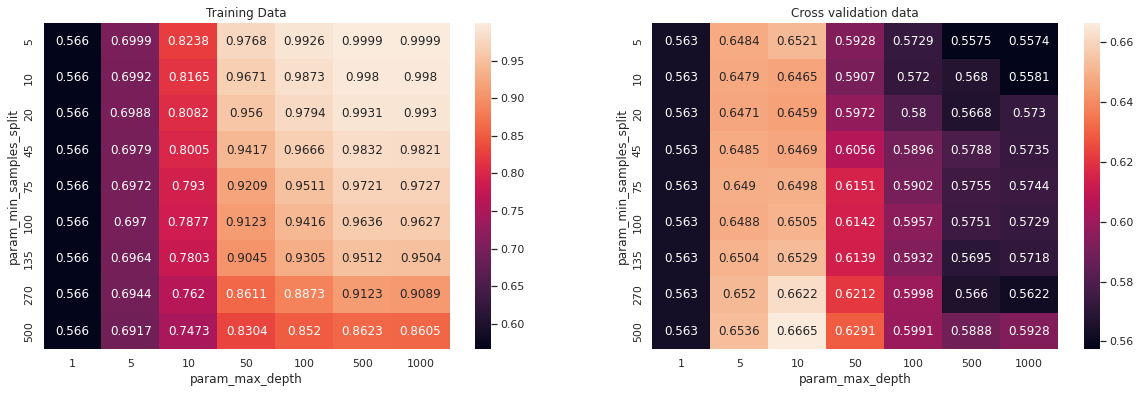

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.7494210453187039
0.6623146971619723


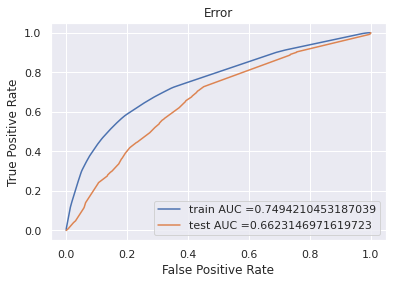

In [65]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns;
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus



DTonedecision = DecisionTreeClassifier(class_weight = 'balanced')
DTparam = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
DToneclf = GridSearchCV(DTonedecision, DTparam, cv=3, scoring='roc_auc',return_train_score=True)
DTonese = DToneclf.fit(X_train1, y_train)

sns.set()
DTmaonescores = pd.DataFrame(DToneclf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(DTmaonescores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(DTmaonescores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Cross validation data')
plt.show()

#Best Estimator and parameters

print(DToneclf.best_estimator_)
print(DToneclf.score(X_train1,y_train))
print(DToneclf.score(X_settest1,y_test))

DTbestunaramete=[{'max_depth':[10], 'min_samples_split':[500] } ]

DToneclf.get_params().keys()

DToneclfone= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),DTbestunaramete)
DTvclfone=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
DToneclfone.fit(X_train1, y_train)
DTvclfone.fit(X_train1, y_train)
DTyraionepred = DToneclfone.predict_proba(X_train1) [:,1]
DTyestred = DToneclfone.predict_proba(X_settest1) [:,1]
DTtraifprone, DTtraitprone, DTtrhresholdsone = roc_curve(y_train, DTyraionepred)
DTtesfprone, DTtestprone, DTtehresholdsone = roc_curve(y_test, DTyestred)
plt.plot(DTtraifprone, DTtraitprone, label="train AUC ="+str(auc(DTtraifprone, DTtraitprone)))
plt.plot(DTtesfprone, DTtestprone, label="test AUC ="+str(auc(DTtesfprone, DTtestprone)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Error")
plt.grid(True)
plt.show()


the maximum value of DTtpr*(1-DTfpr) 0.48 for threshold 0.35
the maximum value of DTtpr*(1-DTfpr) 0.4 for threshold 0.59


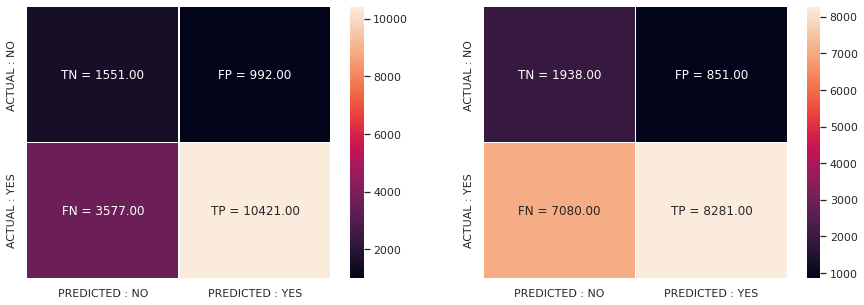

In [67]:
#Confusion Matrix

def DTpredi(DTprob, DTthreshou, DTfpr, DTtpr):
    DTt = DTthreshou[np.argmax(DTfpr*(1-DTtpr))]
    print("the maximum value of DTtpr*(1-DTfpr)", np.round(max(DTtpr*(1-DTfpr)),2) , "for threshold", np.round(DTt,2))
    DTpredicts = []
    global DTonepredicts
    for DTindexone in DTprob:
        if DTindexone>=DTt:
            DTpredicts.append(1)
        else:
            DTpredicts.append(0)
    DTonepredicts= DTpredicts
    return DTpredicts

sns.set()
DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
DTcontest = confusion_matrix(y_test, DTpredi(DTyestred, DTtehresholdsone, DTtesfprone, DTtestprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, DTax = plt.subplots(1,2, figsize=(15,5))
DTlabelrain = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
DTlabeltest = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabelrain, fmt = '', ax=DTax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabeltest, fmt = '', ax=DTax[1])
ax[0].set_title('Training Data Set')
ax[1].set_title('Testing Data Set')
plt.show()


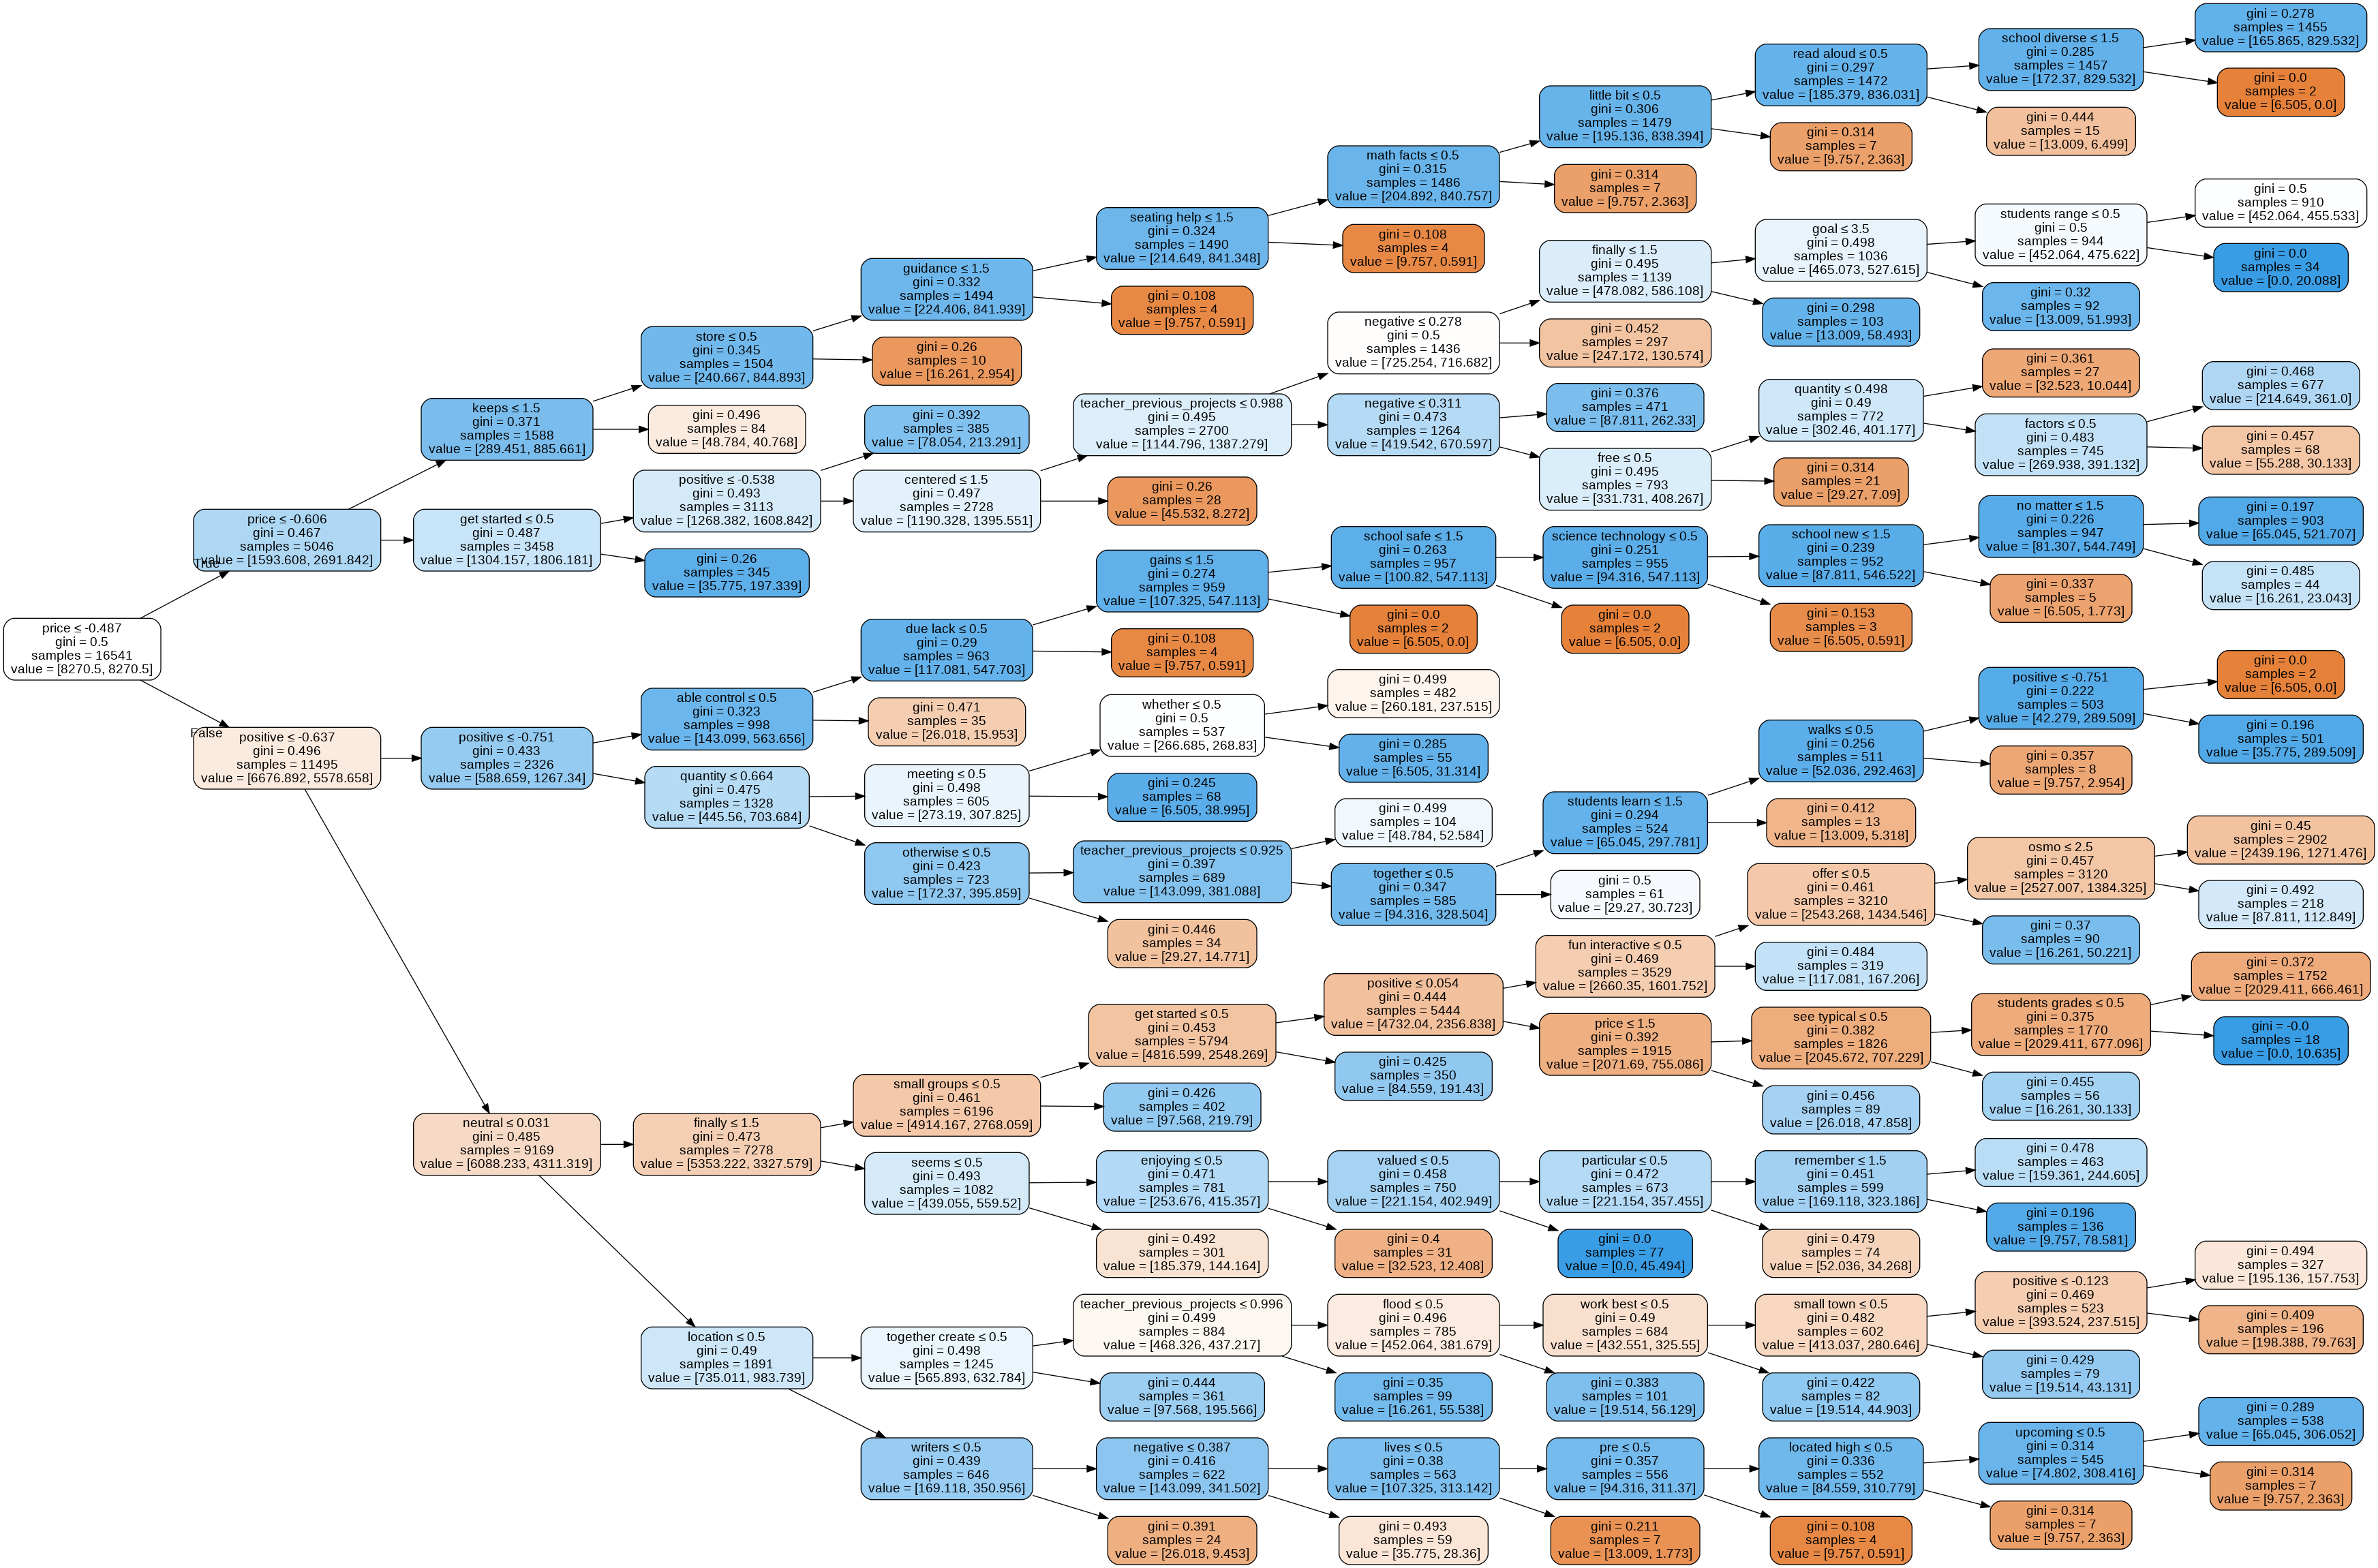

In [68]:
#Visualizing Decision Tree

#Feature aggregation
DTfeatureone=DToneveccleancat.get_feature_names()
DTfeaturetwo=DTtwoveccleancat.get_feature_names()
DTfeaturethree=DTthreeschool.get_feature_names()
DTfeaturefour=DTfourgrade.get_feature_names()
DTfeaturefive=DTfiveteacher.get_feature_names()
DTbfeature=DTvecsix.get_feature_names()
DTtfeature=DTvecseven.get_feature_names()
DTbfeatureone=DTveceight.get_feature_names()
DTtfeatureone=DTvecnine.get_feature_names()

DTfeaturebagofowords = DTfeatureone + DTfeaturetwo + DTfeaturethree + DTfeaturefour + DTfeaturefive + DTbfeature + DTtfeature
DTfeaturetf = DTfeatureone + DTfeaturetwo + DTfeaturethree + DTfeaturefour + DTfeaturefive + DTbfeatureone + DTtfeatureone

DTfeaturebagofowords.append('price')
DTfeaturetf.append('price')
DTfeaturetf.append("positive")
DTfeaturetf.append("neutral")
DTfeaturetf.append("negative")
DTfeaturetf.append("compound")

DTfeaturebagofowords.append("positive")
DTfeaturebagofowords.append("neutral")
DTfeaturebagofowords.append("negative")
DTfeaturebagofowords.append("compound")
DTfeaturebagofowords.append('quantity')
DTfeaturetf.append('quantity')
DTfeaturebagofowords.append('teacher_previous_projects')
DTfeaturetf.append('teacher_previous_projects')

DTdodata = StringIO()
export_graphviz(DTvclfone, out_file=DTdodata, filled=True, rounded=True, special_characters=True, feature_names=DTfeaturebagofowords,rotate=True)
DTgra = pydotplus.graph_from_dot_data(DTdodata.getvalue())
Image(DTgra.create_png())

 False positives Analysis

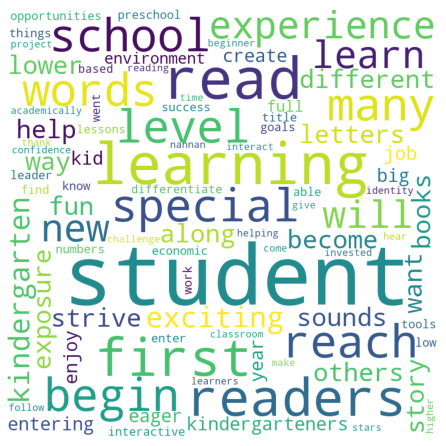

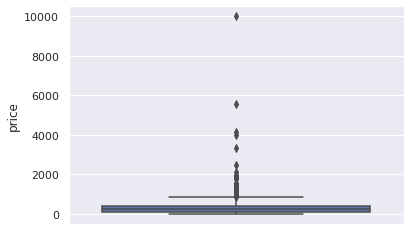

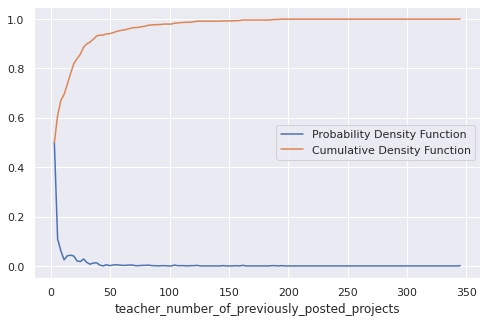

In [69]:
#False positives
X_test['essay'].values[1]

DTfp = []
for DTione in range(len(y_test)) :
  if (y_test.values[DTione] == 0) & (DTonepredicts[DTione] == 1) :
    DTfp.append(DTione)
DTfponeessay = []
for DTione in DTfp :
  DTfponeessay.append(X_test['essay'].values[DTione])

from wordcloud import WordCloud, STOPWORDS
DTcommewords = ' '
stopwords = set(STOPWORDS)
for DTval in DTfponeessay :
  DTval = str(DTval)
  DTtoken = DTval.split()
for DTione in range(len(DTtoken)):
  DTtoken[DTione] = DTtoken[DTione].lower()
for words in DTtoken :
  DTcommewords = DTcommewords + words + ' '
DTwordcld = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(DTcommewords)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(DTwordcld)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


DTcol = X_test.columns
DTtesalsePos = pd.DataFrame(columns=DTcol)


for indexvalue in DTfp :
    
  DTtesalsePos = DTtesalsePos.append(X_test.filter(items=[indexvalue], axis=0))

DTtesalsePos.head(1)
len(DTtesalsePos)

sns.boxplot(y='price', data=DTtesalsePos)

plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(DTtesalsePos['teacher_number_of_previously_posted_projects'],
bins='auto', density=True)
probability_density_function = counts/sum(counts)
comulative_density_function = np.cumsum(probability_density_function)
probability_density_functionone, = plt.plot(bin_edges[1:], probability_density_function)
comulative_density_functionone, = plt.plot(bin_edges[1:], comulative_density_function)
plt.legend([probability_density_functionone, comulative_density_functionone], ["Probability Density Function", "Cumulative Density Function"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Applying Decision trees on TFIDF

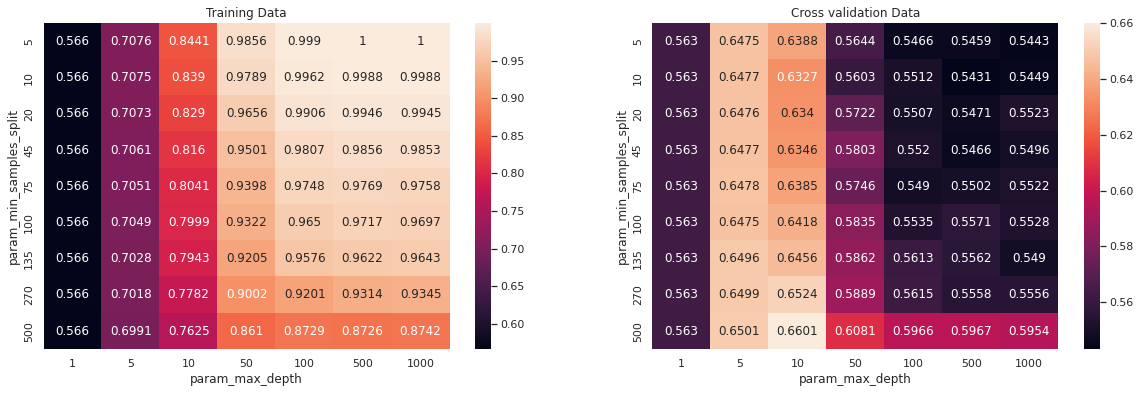

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.7581081888165924
0.6587019662489199


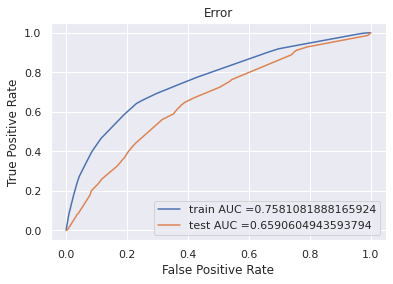

In [70]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns; 


DTtwodecision = DecisionTreeClassifier(class_weight = 'balanced')
DTtwoparam = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
DTclftwo = GridSearchCV(DTtwodecision, DTtwoparam, cv=3, scoring='roc_auc',return_train_score=True)
DTtwose = DTclftwo.fit(X_settrain2, y_train)

sns.set()
DTmaonescores = pd.DataFrame(DTclftwo.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(DTmaonescores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(DTmaonescores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Cross validation Data')
plt.show()

#Best Estimator and parameters
print(DTclftwo.best_estimator_)
print(DTclftwo.score(X_settrain2,y_train))
print(DTclftwo.score(X_setst2,y_test))

DTbestunaramete=[{'max_depth':[10], 'min_samples_split':[500] }]
DToneclfone= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),DTbestunaramete)
DTvclfone=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
DToneclfone.fit(X_settrain2, y_train)
DTvclfone.fit(X_settrain2, y_train)

DTyraionepred = DToneclfone.predict_proba(X_settrain2) [:,1]
DTyestred = DToneclfone.predict_proba(X_setst2) [:,1]

DTtraifprone, DTtraitprone, DTtrhresholdsone = roc_curve(y_train, DTyraionepred)
DTtesfprone, DTtestprone, DTtehresholdsone = roc_curve(y_test, DTyestred)

plt.plot(DTtraifprone, DTtraitprone, label="train AUC ="+str(auc(DTtraifprone, DTtraitprone)))
plt.plot(DTtesfprone, DTtestprone, label="test AUC ="+str(auc(DTtesfprone, DTtestprone)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Error")
plt.grid(True)
plt.show()


the maximum value of DTtpr*(1-DTfpr) 0.49 for threshold 0.38
the maximum value of DTtpr*(1-DTfpr) 0.4 for threshold 0.58


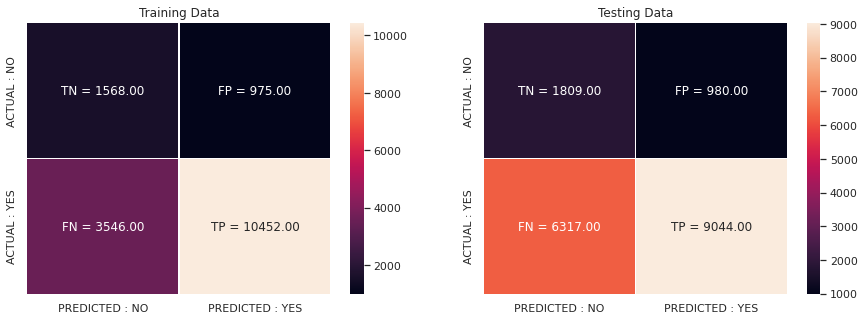

In [71]:
#Confusion matrix

DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
DTcontest = confusion_matrix(y_test, DTpredi(DTyestred, DTtehresholdsone, DTtesfprone, DTtestprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
DTlabelrain = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
DTlabeltest = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabelrain, fmt = '', ax=ax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabeltest, fmt = '', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
plt.show()

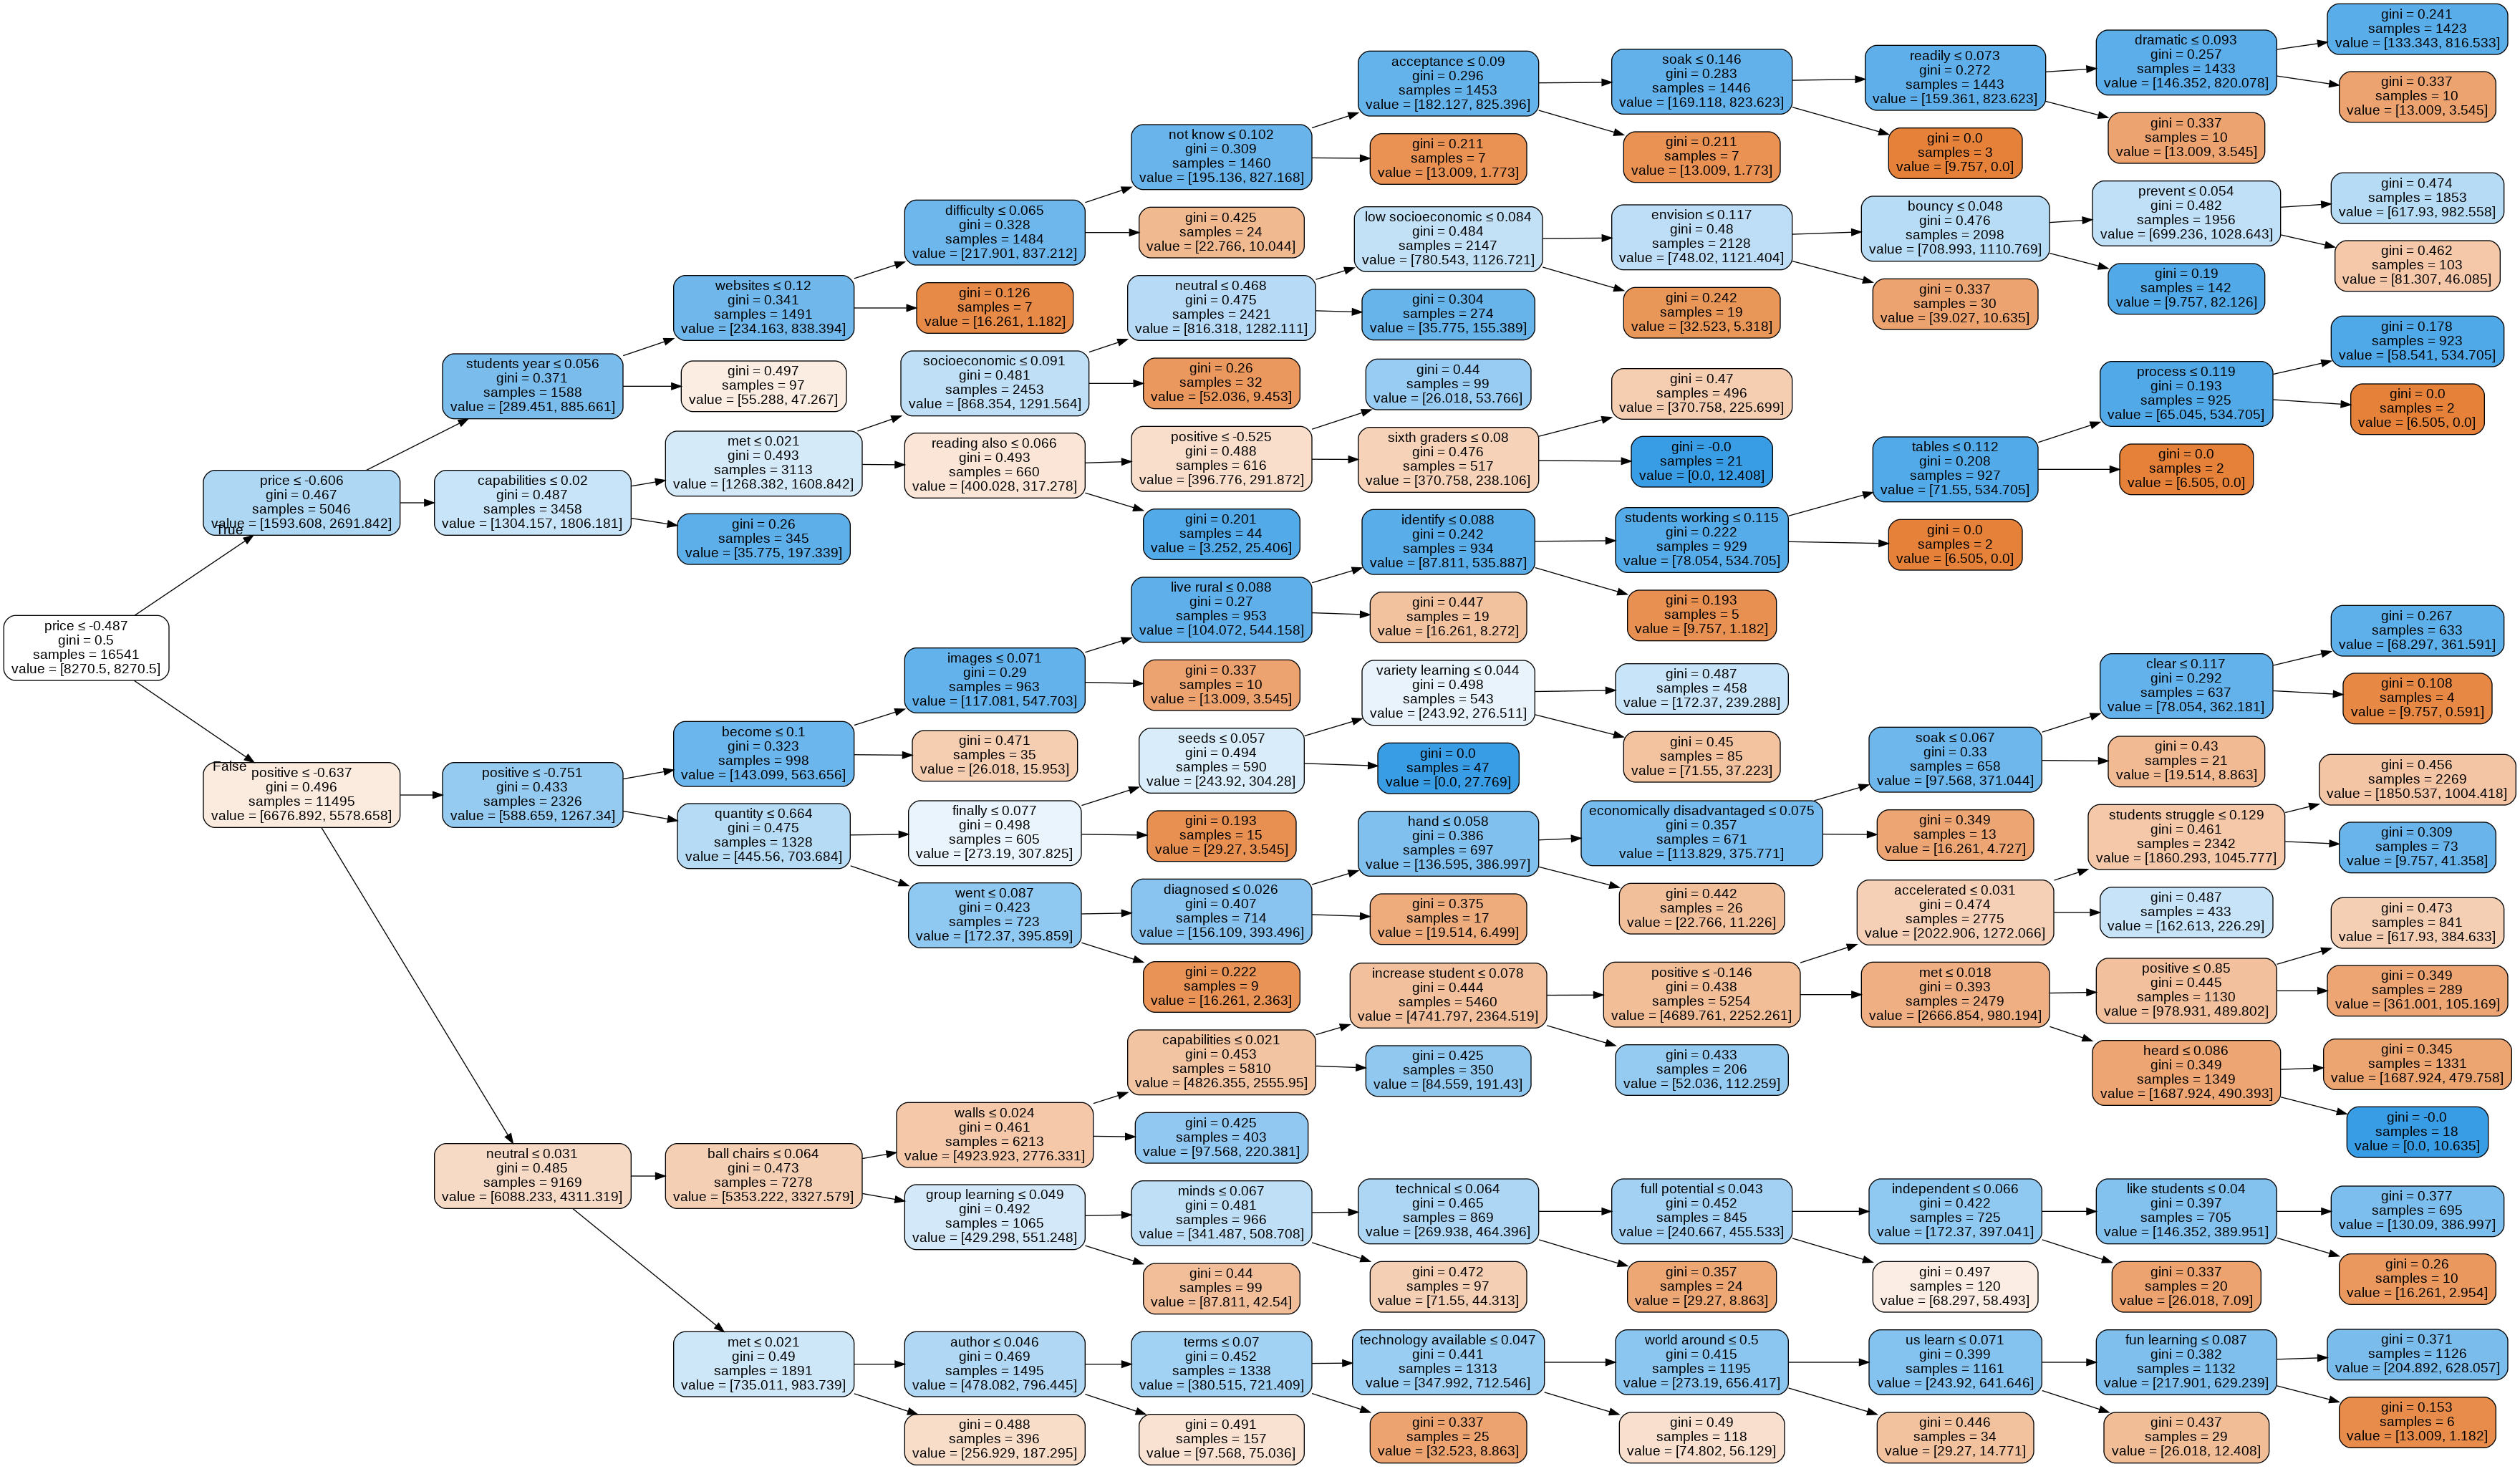

In [72]:
#Decision Tree
DTdodata = StringIO()
export_graphviz(DTvclfone, out_file=DTdodata, filled=True, rounded=True, special_characters=True, feature_names=DTfeaturebagofowords,rotate=True)
DTgra = pydotplus.graph_from_dot_data(DTdodata.getvalue())
Image(DTgra.create_png())

Analysis on the False positives

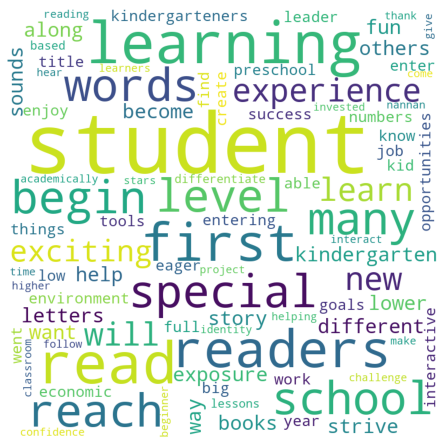

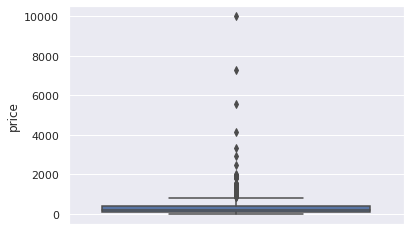

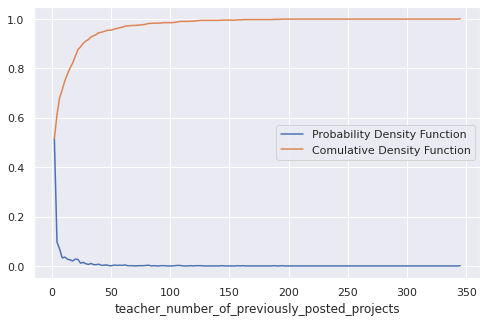

In [73]:
from wordcloud import WordCloud, STOPWORDS

DTfp = []
for DTione in range(len(y_test)) :
  if (y_test.values[DTione] == 0) & (DTonepredicts[DTione] == 1) :
    DTfp.append(DTione)
DTfponeessay = []
for DTione in DTfp :
  DTfponeessay.append(X_test['essay'].values[DTione])

DTcommewords = ' '
stopwords = set(STOPWORDS)
for DTval in DTfponeessay :
  DTval = str(DTval)
  DTtoken = DTval.split()
for DTione in range(len(DTtoken)):
  DTtoken[DTione] = DTtoken[DTione].lower()
for words in DTtoken :
  DTcommewords = DTcommewords + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(DTcommewords)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#False Positive 

DTcol = X_test.columns
DTtesalsePos = pd.DataFrame(columns=DTcol)

for DTione in DTfp :
  DTtesalsePos = DTtesalsePos.append(X_test.filter(items=[DTione], axis=0))

#Box Plot
sns.boxplot(y='price', data=DTtesalsePos)

#Probability Density Function(teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(DTtesalsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
probability_density_function = counts/sum(counts)
comulative_density_function = np.cumsum(probability_density_function)
probability_density_functionone, = plt.plot(bin_edges[1:], probability_density_function)
comulative_density_functionone, = plt.plot(bin_edges[1:], comulative_density_function)
plt.legend([probability_density_functionone, comulative_density_functionone], ["Probability Density Function", "Comulative Density Function"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Applying Decision trees on AVG W2V

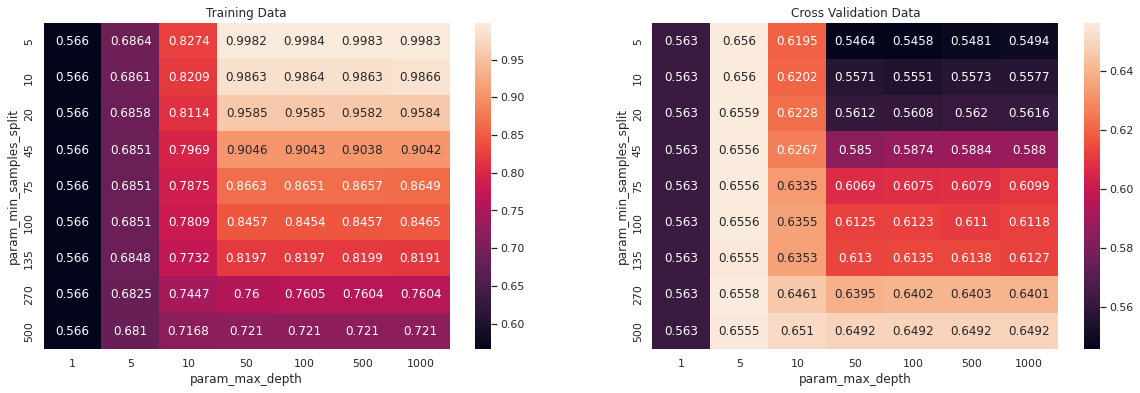

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.6803585417544903
0.6369696307783684


In [74]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
DTthreedecision= DecisionTreeClassifier(class_weight = 'balanced')
DTparam = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
DTthreeclf = GridSearchCV(DTthreedecision, DTparam, cv=3, scoring='roc_auc',n_jobs=4,return_train_score=True)
DTthreese = DTthreeclf.fit(X_strain3, y_train)

import seaborn as sns; sns.set()
DTmaonescores = pd.DataFrame(DTthreeclf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(DTmaonescores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(DTmaonescores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Cross Validation Data')
plt.show()

#Best Estimator and parameters
print(DTthreeclf.best_estimator_)
print(DTthreeclf.score(X_strain3,y_train))
print(DTthreeclf.score(X_sette3,y_test))

DTbestunaramete=[{'max_depth':[5], 'min_samples_split':[500] } ]

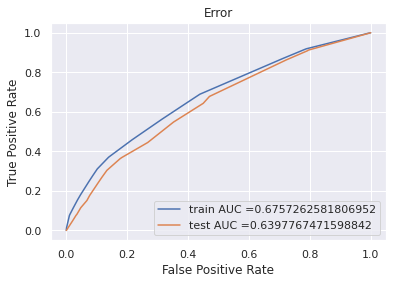

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
DToneclfone= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),DTbestunaramete)
DTvclfone=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
DToneclfone.fit(X_strain3, y_train)
# Visualization
DTvclfone.fit(X_strain3, y_train)
DTyraionepred = DToneclfone.predict_proba(X_strain3) [:,1]
DTyestred = DToneclfone.predict_proba(X_sette3) [:,1]
DTtraifprone, DTtraitprone, DTtrhresholdsone = roc_curve(y_train, DTyraionepred)
DTtesfprone, DTtestprone, DTtehresholdsone = roc_curve(y_test, DTyestred)
plt.plot(DTtraifprone, DTtraitprone, label="train AUC ="+str(auc(DTtraifprone, DTtraitprone)))
plt.plot(DTtesfprone, DTtestprone, label="test AUC ="+str(auc(DTtesfprone, DTtestprone)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Error")
plt.grid(True)
plt.show()

the maximum value of DTtpr*(1-DTfpr) 0.39 for threshold 0.5
the maximum value of DTtpr*(1-DTfpr) 0.36 for threshold 0.5


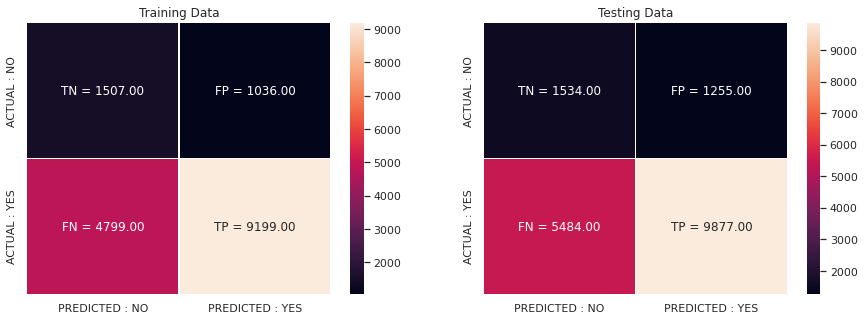

In [76]:
import seaborn as sns; sns.set()
DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
DTcontest = confusion_matrix(y_test, DTpredi(DTyestred, DTtehresholdsone, DTtesfprone, DTtestprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],
yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],
yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
plt.show()

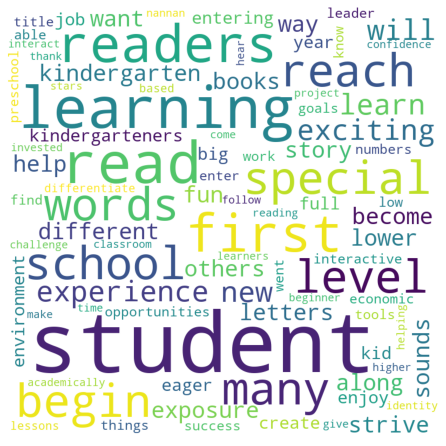

In [77]:
#False positives
DTfp = []
for DTione in range(len(y_test)) :
  if (y_test.values[DTione] == 0) & (DTonepredicts[DTione] == 1) :
    DTfp.append(DTione)
DTfponeessay = []
for DTione in DTfp :
  DTfponeessay.append(X_test['essay'].values[DTione])

#Word cloud
from wordcloud import WordCloud, STOPWORDS
DTcommewords = ' '
stopwords = set(STOPWORDS)
for DTval in DTfponeessay :
  DTval = str(DTval)
  tokens = DTval.split()
for indexvalue in range(len(tokens)):
  tokens[indexvalue] = tokens[indexvalue].lower()
for words in tokens :
  DTcommewords = DTcommewords + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(DTcommewords)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

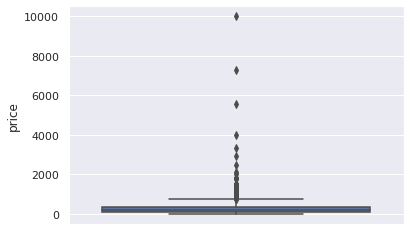

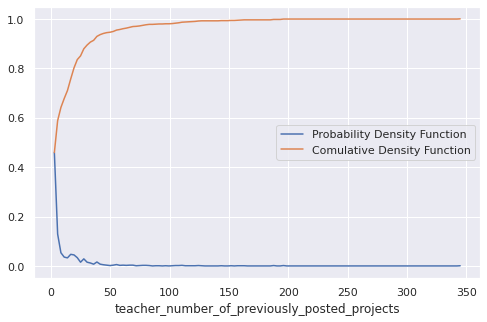

In [78]:
#False Positives

pfcol = X_test.columns
DTtesalsePos = pd.DataFrame(columns=pfcol)

for indexvalue in DTfp :
  DTtesalsePos = DTtesalsePos.append(X_test.filter(items=[indexvalue], axis=0))

#Box Plot
sns.boxplot(y='price', data=DTtesalsePos)

#Probability Density Function(teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(DTtesalsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
probability_density_function = counts/sum(counts)
comulative_density_function = np.cumsum(probability_density_function)
probability_density_functionone, = plt.plot(bin_edges[1:], probability_density_function)
comulative_density_functionone, = plt.plot(bin_edges[1:], comulative_density_function)
plt.legend([probability_density_functionone, comulative_density_functionone], ["Probability Density Function", "Comulative Density Function"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Applying Decision trees on td_idf W2V

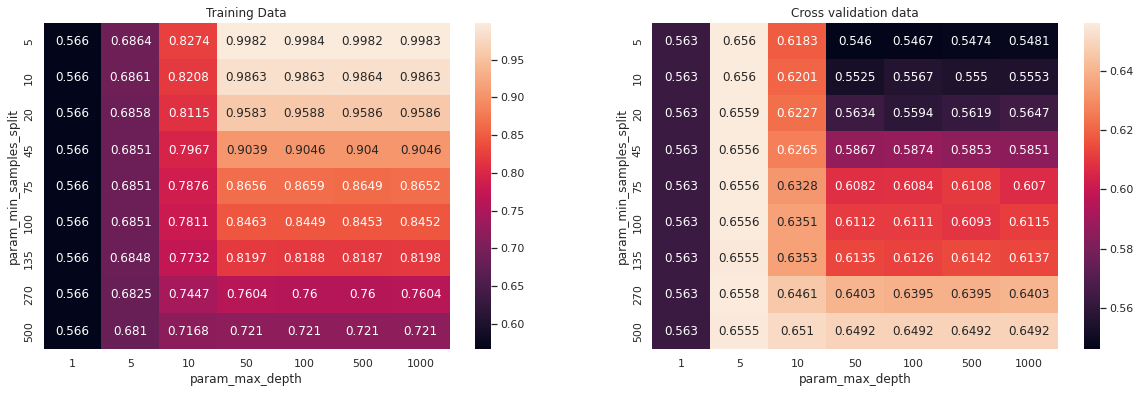

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.6803585417544903
0.6369696307783684


In [79]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
DTfourdecision= DecisionTreeClassifier(class_weight = 'balanced')
DTparam = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
DTfourclf = GridSearchCV(DTfourdecision, DTparam, cv=3, scoring='roc_auc',return_train_score=True)
DTfourse= DTfourclf.fit(X_setra4, y_train)

import seaborn as sns; sns.set()
DTmaonescores = pd.DataFrame(DTfourclf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(DTmaonescores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(DTmaonescores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Cross validation data')
plt.show()

#Best Estimator and parameters
print(DTfourclf.best_estimator_)
print(DTfourclf.score(X_setra4,y_train))
print(DTfourclf.score(X_setes4,y_test))

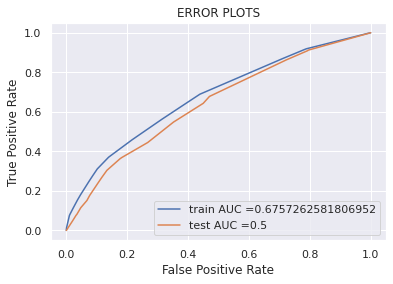

the maximum value of DTtpr*(1-DTfpr) 0.39 for threshold 0.5
the maximum value of DTtpr*(1-DTfpr) 0.36 for threshold 0.5


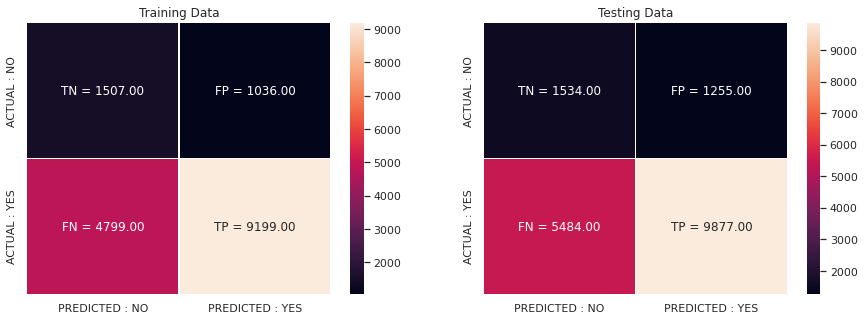

In [80]:
DTbestunaramete= [{'max_depth': [5], 'min_samples_split':[500] }]

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
DToneclfone= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),DTbestunaramete)
DTvclfone=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
DToneclfone.fit(X_setra4, y_train)
# Visualization
DTvclfone.fit(X_setra4, y_train)

DTyraionepred = DToneclfone.predict_proba(X_setra4) [:,1]
DTyestred = DToneclfone.predict_proba(X_setes4) [:,1]
DTtraifprone, DTtraitprone, DTtrhresholdsone = roc_curve(y_train, DTyraionepred)
DTtesfprone, DTtestprone, DTtehresholdsone = roc_curve(y_test, DTyestred)
plt.plot(DTtraifprone, DTtraitprone, label="train AUC ="+str(auc(DTtraifprone, DTtraitprone)))
plt.plot(DTtesfprone, DTtestprone, label="test AUC ="+str(auc(DTtestprone, DTtestprone)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

#CONFUSION MATRIX

import seaborn as sns; sns.set()
DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
DTcontest = confusion_matrix(y_test, DTpredi(DTyestred, DTtehresholdsone, DTtesfprone, DTtestprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
DTlabelrain = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
DTlabeltest = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabelrain, fmt = '', ax=ax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabeltest, fmt = '', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
plt.show()

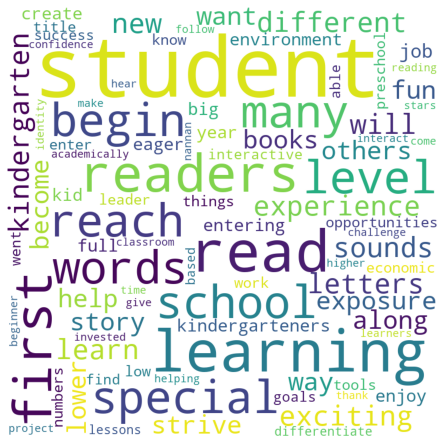

In [81]:
#False positives
DTfp = []
for indexvalue in range(len(y_test)) :
  if (y_test.values[indexvalue] == 0) & (DTonepredicts[indexvalue] == 1) :
   DTfp.append(indexvalue)
DTfponeessay = []
for indexvalue in DTfp :
  DTfponeessay.append(X_test['essay'].values[indexvalue])

#WORD CLOUD
from wordcloud import WordCloud, STOPWORDS
DTcommewords = ' '
stopwords = set(STOPWORDS)
for DTval in DTfponeessay :
  DTval = str(DTval)
  DTtoken = DTval.split()
for indexvalue in range(len(DTtoken)):
  DTtoken[indexvalue] = DTtoken[indexvalue].lower()
for DTwods in DTtoken :
  DTcommewords = DTcommewords + DTwods + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(DTcommewords)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

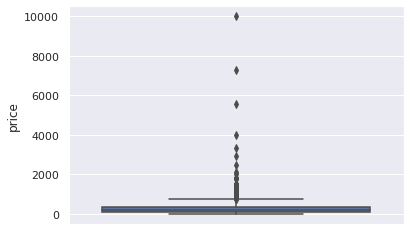

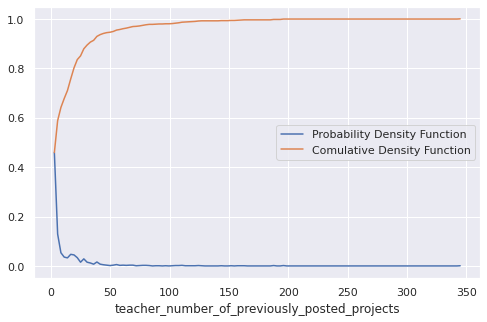

In [82]:
#Box Plot
DTcol = X_test.columns
DTtesalsePos = pd.DataFrame(columns=DTcol)

for indexvalue in DTfp :
  DTtesalsePos = DTtesalsePos.append(X_test.filter(items=[indexvalue], axis=0))
sns.boxplot(y='price', data=DTtesalsePos)

#Probability Density Function(teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(DTtesalsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
probability_density_function = counts/sum(counts)
comulative_density_function = np.cumsum(probability_density_function)
probability_density_functionone, = plt.plot(bin_edges[1:], probability_density_function)
comulative_density_functionone, = plt.plot(bin_edges[1:], comulative_density_function)
plt.legend([probability_density_functionone, comulative_density_functionone], ["Probability Density Function", "Comulative Density Function"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Decision tree on Important features

(16541, 5000)
(16541, 5000)


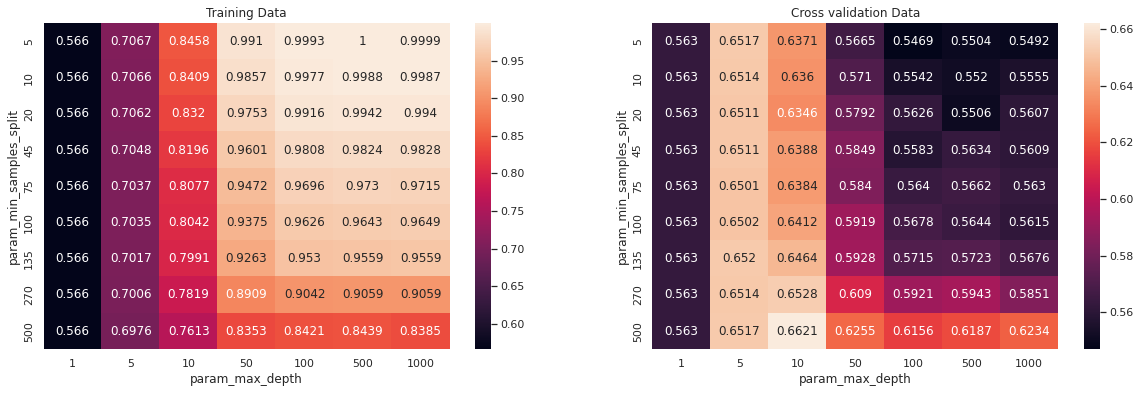

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.7581081888165924


In [83]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def DTselKImp(model, X, k=5):
    return X[:,model.best_estimator_.feature_importances_.argsort()[::-1][:k]]

DTsettrain = DTselKImp(DTclftwo, xtr,5000)
DTsetest = DTselKImp(DTclftwo,xte , 5000)

print(DTsettrain.shape)
print(DTsetest.shape)

DTfivedecision= DecisionTreeClassifier(class_weight = 'balanced')
DTparam = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
DTfiveclf = GridSearchCV(DTfivedecision, DTparam, cv=3, scoring='roc_auc',return_train_score=True)
DTse5= DTfiveclf.fit(DTsettrain, y_train)


import seaborn as sns; sns.set()
DTmaonescores = pd.DataFrame(DTfiveclf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(DTmaonescores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(DTmaonescores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Cross validation Data')
plt.show()

#Best Estimator and parameters
print(DTfiveclf.best_estimator_)
#Mean cross-validated score of the best_estimator
print(DTfiveclf.score(DTsettrain,y_train))

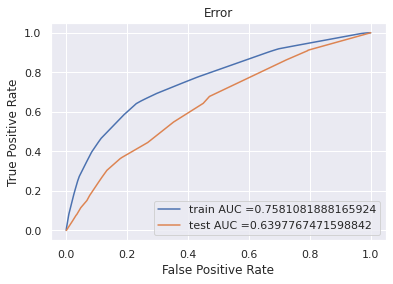

the maximum value of DTtpr*(1-DTfpr) 0.49 for threshold 0.38


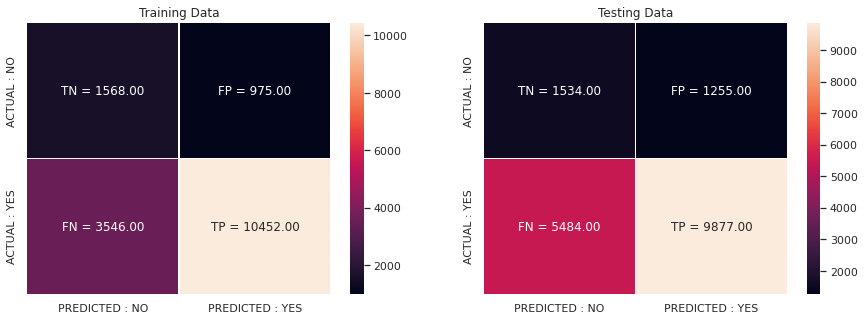

In [84]:
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

DTbestunaramete=[{'max_depth': [10], 'min_samples_split':[500] } ]

DToneclfone= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),DTbestunaramete)
DTvclfone=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
DToneclfone.fit(DTsettrain, y_train)
# Visual
DTvclfone.fit(DTsettrain, y_train)

DTyraionepred = DToneclfone.predict_proba(DTsettrain) [:,1]
DTyestred = DToneclfone.predict_proba(DTsetest) [:,1]
DTtraifprone, DTtraitprone, DTtrhresholdsone = roc_curve(y_train, DTyraionepred)
plt.plot(DTtraifprone, DTtraitprone, label="train AUC ="+str(auc(DTtraifprone, DTtraitprone)))
plt.plot(DTtesfprone, DTtestprone, label="test AUC ="+str(auc(DTtesfprone, DTtestprone)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Error")
plt.grid(True)
plt.show()

#Confusion Matrix

import seaborn as sns; sns.set()
DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
DTlabelrain = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
DTlabeltest = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabelrain, fmt = '', ax=ax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabeltest, fmt = '', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
plt.show()

the maximum value of DTtpr*(1-DTfpr) 0.49 for threshold 0.38


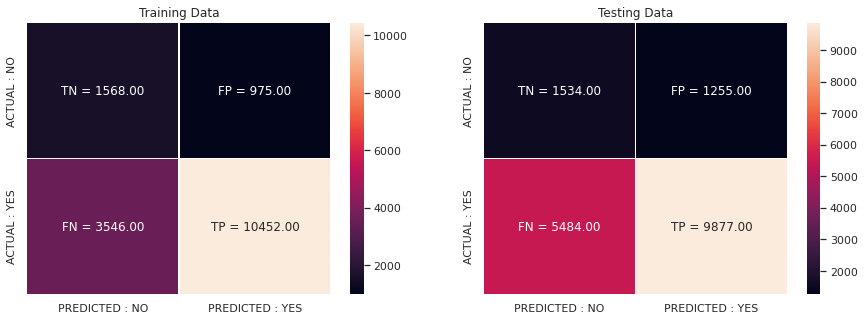

In [85]:
#Confusion matrix
import seaborn as sns; sns.set()
DTcontrain = confusion_matrix(y_train, DTpredi(DTyraionepred, DTtrhresholdsone, DTtraifprone, DTtraitprone))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
DTlabelrain = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), DTcontrain.flatten())])).reshape(2,2)
DTlabeltest = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
DTcontest.flatten())])).reshape(2,2)
sns.heatmap(DTcontrain, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabelrain, fmt = '', ax=ax[0])
sns.heatmap(DTcontest, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = DTlabeltest, fmt = '', ax=ax[1])
ax[0].set_title('Training Data')
ax[1].set_title('Testing Data')
plt.show()

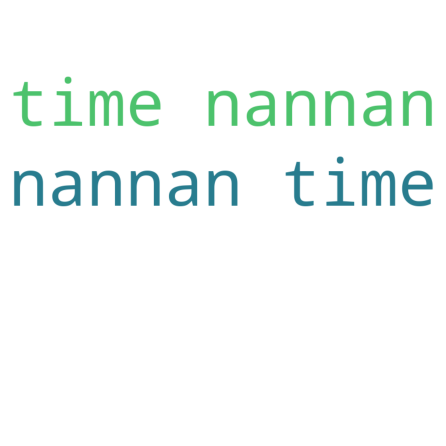

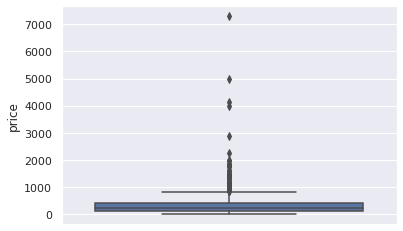

In [86]:
#False positives

DTfp = []
for indexvalue in range(len(y_train)) :
    if (y_train.values[indexvalue] == 0) & (DTonepredicts[indexvalue] == 1) :
      DTfp.append(indexvalue)
DTfponeessay = []
for indexvalue in DTfp :
  DTfponeessay.append(X_test['essay'].values[indexvalue])
  
# Word cloud
from wordcloud import WordCloud, STOPWORDS
DTcommewords = ' '
stopwords = set(STOPWORDS)
for DTval in DTfponeessay :
  DTval = str(DTval)
  DTtoken = DTval.split()
for indexvalue in range(len(DTtoken)):
  DTtoken[indexvalue] = DTtoken[indexvalue].lower()
for words in DTtoken :
  DTcommewords = DTcommewords + DTwods + ' '

DTwordcld = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(DTcommewords)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(DTwordcld)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#Box Plot
DTcol = X_test.columns
DTtesalsePos = pd.DataFrame(columns=DTcol)

for indexvalue in DTfp :
  DTtesalsePos = DTtesalsePos.append(X_test.filter(items=[indexvalue], axis=0))
sns.boxplot(y='price', data=DTtesalsePos)

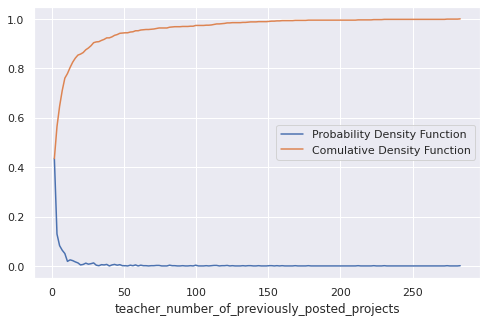

In [87]:
#Probability Density Function(teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(DTtesalsePos['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
probability_density_function = counts/sum(counts)
comulative_density_function = np.cumsum(probability_density_function)
probability_density_functionone, = plt.plot(bin_edges[1:], probability_density_function)
comulative_density_functionone, = plt.plot(bin_edges[1:], comulative_density_function)
plt.legend([probability_density_functionone, comulative_density_functionone], ["Probability Density Function", "Comulative Density Function"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Conclusions

In [88]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth "," AUC ")
tb.add_row([" Bagofwords ", 10, 74.6])
tb.add_row([" TfIdf", 10 ,77.1 ])
tb.add_row([" Average-Word2Vec", 5, 67.8 ])
tb.add_row(["Average TfIdf", 5 ,67.8])
tb.add_row(["Top 5000 Features", 10,77.1 ])
print(tb.get_string(titles = "Decision trees"))

+-------------------+-------------+-------+
|     Vectorizer    |  Max_depth  |  AUC  |
+-------------------+-------------+-------+
|     Bagofwords    |      10     |  74.6 |
|        TfIdf      |      10     |  77.1 |
|  Average-Word2Vec |      5      |  67.8 |
|   Average TfIdf   |      5      |  67.8 |
| Top 5000 Features |      10     |  77.1 |
+-------------------+-------------+-------+
